In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')
df = housing.data.copy(deep=True)
df = df.astype({'Id': int})
df = df.set_index('Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [3]:
X = housing.data
y = housing.target

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

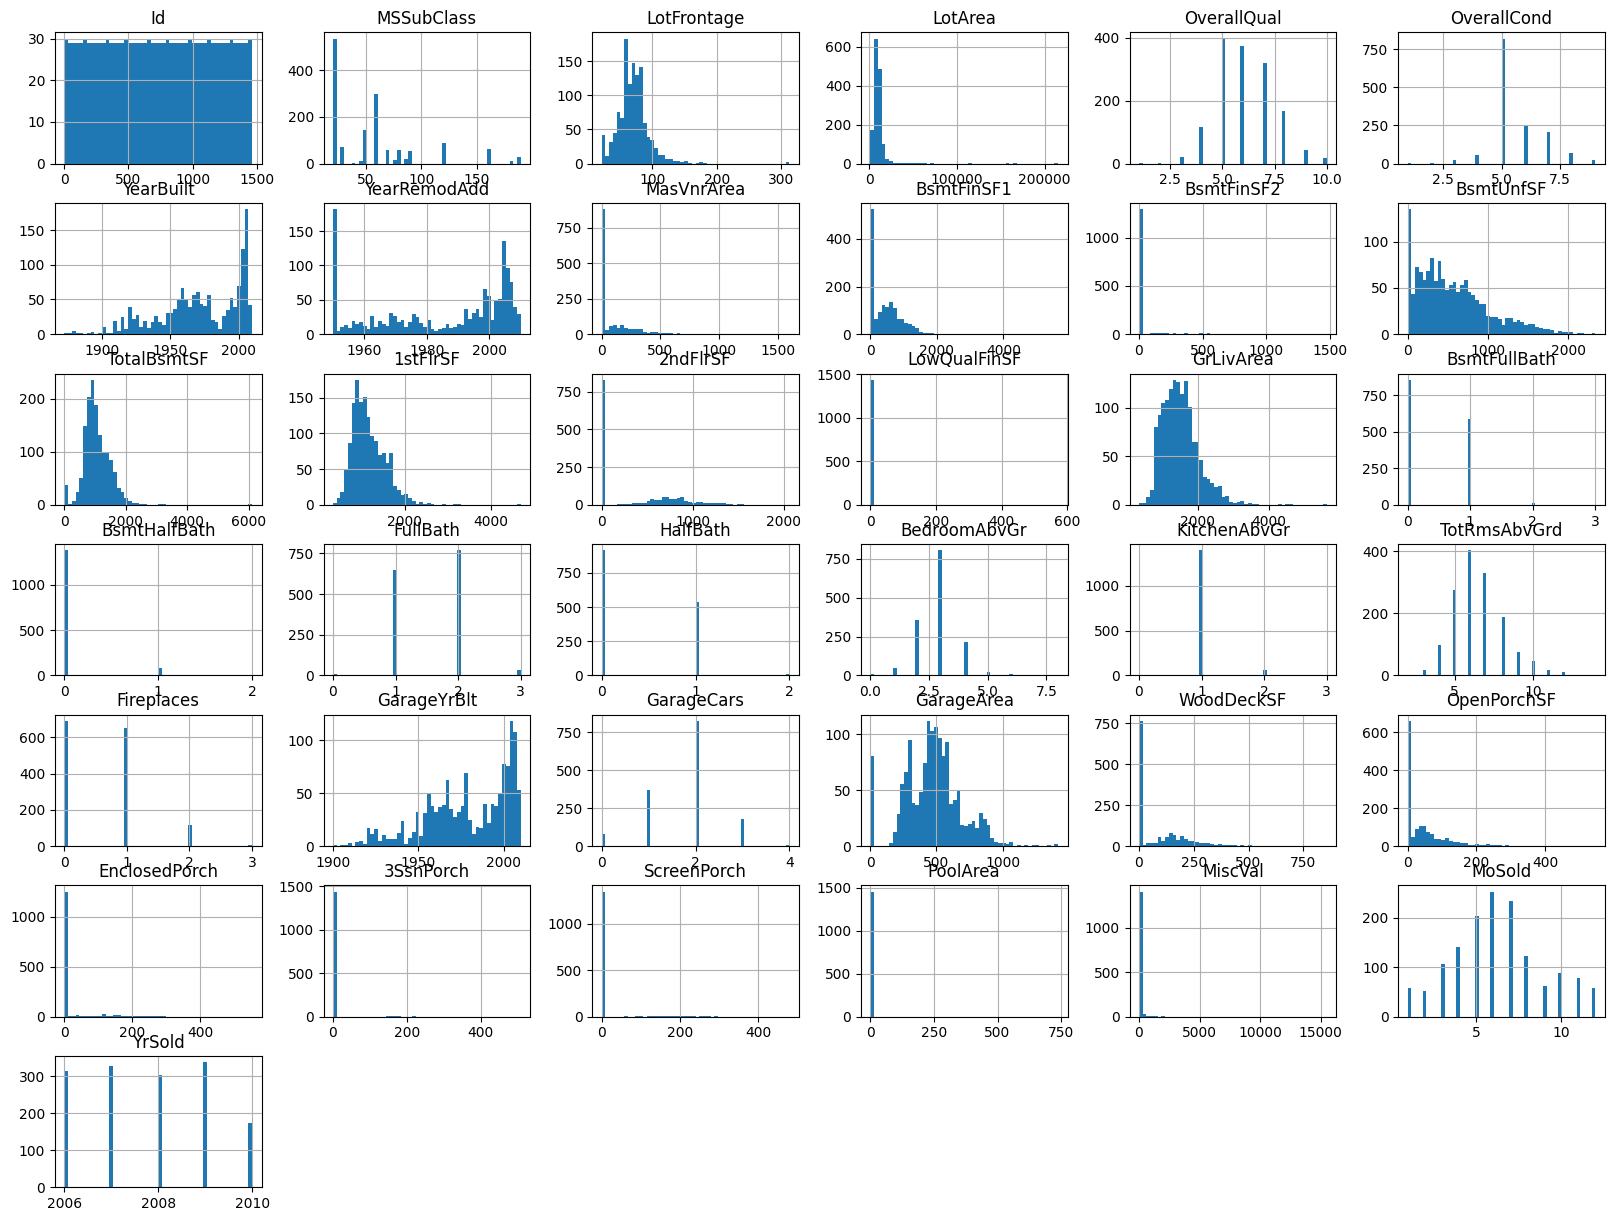

In [ ]:
X.hist(bins=50, figsize=(20,15))

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_attribs = X.select_dtypes(["int64", "float64"]).columns
cat_attribs = X.select_dtypes(["object"]).columns

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

full_pipeline.set_output(transform="pandas")
X_prep = full_pipeline.fit_transform(X)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size = 0.2, random_state = 42)

In [15]:
X_train.head()

,num__Id,num__MSSubClass,num__LotFrontage,num__LotArea,num__OverallQual,num__OverallCond,num__YearBuilt,num__YearRemodAdd,num__MasVnrArea,num__BsmtFinSF1,...,cat__SaleType_ConLw,cat__SaleType_New,cat__SaleType_Oth,cat__SaleType_WD,cat__SaleCondition_Abnorml,cat__SaleCondition_AdjLand,cat__SaleCondition_Alloca,cat__SaleCondition_Family,cat__SaleCondition_Normal,cat__SaleCondition_Partial
254,-1.126641,-0.871172,0.020575,-0.207843,-0.795063,0.380541,-0.469853,-1.347508,-0.573757,1.127646,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1065,0.797084,0.073476,0.499122,0.360260,0.665646,-0.517461,0.821913,0.590003,-0.573757,1.776322,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
637,-0.218149,3.143582,-0.936520,-0.451315,-0.795063,-1.415464,-0.569220,-1.492821,-0.573757,-1.016005,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1292,1.335537,0.309638,-0.457972,-0.390447,-0.795063,-1.415464,-2.622797,-0.960006,-0.573757,-1.016005,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
514,-0.509910,-0.280767,-0.697246,0.014732,-0.795063,-0.517461,-1.496642,-1.686572,-0.573757,-1.016005,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.001, random_state=42)
sgd_reg.fit(X_train, y_train)
y_pred = sgd_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse ** 0.5

31425.3279930656

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'max_iter': [500, 1000, 2000],
     'eta0': [0.005, 0.001, 0.0005, 0.0001],
     'tol': [1e-3],
     'random_state': [42]}
]
sgd_reg_best = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
sgd_reg_best.fit(X_train, y_train)

In [ ]:
sgd_reg_best.best_params_

In [ ]:
sgd_reg_after_gridsearch = SGDRegressor(max_iter=500, tol=1e-3, penalty=None, eta0=0.005, random_state=42)
sgd_reg_after_gridsearch.fit(X_train, y_train)
y_pred = sgd_reg_after_gridsearch.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

In [ ]:
rmse = mse ** 0.5
rmse

In [ ]:
y_test.describe()

In [ ]:
x_train_patch_grad = X_train['num__GrLivArea'].values

y_train_arr = y_train.values

a = 0.0
b = 0.0
n_epochs = 1000
lr = 0.01

for epoch in range(n_epochs):
    yhat = a + b * x_train_patch_grad
    error = (y_train_arr - yhat)

    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train_patch_grad * error).mean()

    a = a - lr * a_grad
    b = b - lr * b_grad

print(a, b)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(
    x=x_train_patch_grad,
    y=y_train_arr,
    line_kws={'color': 'red'},
)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_lin_reg)
mse ** 0.5

In [ ]:
X_test[0:5]
lin_reg.predict(X_test[0:5])

In [ ]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X_train, y_train)
y_pred_ridge_reg = ridge_reg.predict(X_test)
mse = mean_squared_error(y_pred_ridge_reg, y_test)
mse ** 0.5

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)
y_pred_lasso_reg = lasso_reg.predict(X_test)
mse = mean_squared_error(y_pred_lasso_reg, y_test)
mse ** 0.5

In [ ]:
from sklearn.linear_model import ElasticNetCV
el_net_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_jobs=-1, random_state=42)
el_net_cv.fit(X_train, y_train)

In [ ]:
print(el_net_cv.l1_ratio_)
print(el_net_cv.alpha_)

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=196, l1_ratio=1)
elastic_net.fit(X_train, y_train)
y_pred_elastic_net = elastic_net.predict(X_test)
mse = mean_squared_error(y_pred_elastic_net, y_test)
mse ** 0.5

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_rmse = -train_scores.mean(axis=1)
    test_rmse = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_rmse, "r-+", linewidth=2, label="Train")
    plt.plot(train_sizes, test_rmse, "b-", linewidth=3, label="Val")

    plt.title(f"Learning Curves for Elastic Net")
    plt.xlabel("Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(lasso_reg, X_train, y_train)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_train_poly, y_train)
y_pred_poly = lin_reg_poly.predict(X_test_poly)


In [ ]:
mse = mean_squared_error(y_pred_poly, y_test)
mse ** 0.5

In [ ]:
# Try to impove

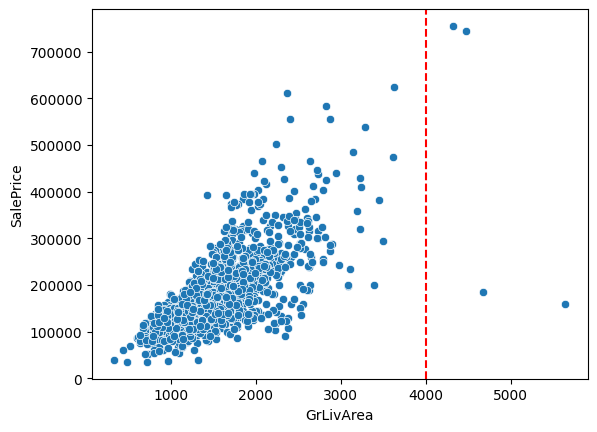

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=X['GrLivArea'], y=y)
plt.axvline(x=4000, color='r', linestyle='--')
plt.show()


In [10]:
outliers = X[X['GrLivArea']>4000].index

In [11]:
X = X.drop(outliers)
y = y.drop(outliers)

In [16]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge

model_log = TransformedTargetRegressor(
    regressor=Ridge(alpha=30, solver="saga"),
    func=np.log1p,
    inverse_func=np.expm1
)
model_log.fit(X_train, y_train)
y_pred_model_log = model_log.predict(X_test)
mse = mean_squared_error(y_pred_model_log, y_test)
mse ** 0.5

19712.816517997526

In [40]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(epsilon=0.1, C=10000)
lin_svr.fit(X_train, y_train)
y_pred_lin_svr = lin_svr.predict(X_test)
mse = mean_squared_error(y_pred_lin_svr, y_test)
mse ** 0.5

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


21157.141114297865

In [36]:
from sklearn.svm import SVR

poly_svr = SVR(kernel="poly", degree=2, C=100000, epsilon=0.1)
poly_svr.fit(X_train, y_train)
y_pred_poly_svr = poly_svr.predict(X_test)
mse = mean_squared_error(y_pred_poly_svr, y_test)
mse ** 0.5

20913.450703379425

In [49]:
from sklearn.svm import SVR

rbf_svr = SVR(kernel="rbf", C=100000, epsilon=10)
rbf_svr.fit(X_train, y_train)
y_pred_rbf_svr = rbf_svr.predict(X_test)
mse = mean_squared_error(y_pred_rbf_svr, y_test)
mse ** 0.5

21853.482683406924